# Modeling Extremes - Numpyro Pt 2 - MAP

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # first gpu
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'FALSE'

import jax
jax.config.update('jax_platform_name', 'cpu')

import numpyro
numpyro.set_platform("cpu")

In [2]:
import autoroot
from pathlib import Path
import numpy as np
import xarray as xr
import pandas as pd
import pint_xarray

from dynev4eo._src.preprocess.masks import add_country_mask
from dynev4eo._src.extremes.returns import calculate_exceedence_probs
from dynev4eo._src.viz.ts import plot_ts_station_bm, plot_scatter_station, plot_histogram_station
from dynev4eo._src.models.station.gevd import ProbGEVDIID


import jax
import jax.random as jrandom
import jax.numpy as jnp
import pandas as pd

rng_key = jrandom.PRNGKey(123)

from numpyro.infer import Predictive
import arviz as az

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
import xarray as xr
import regionmask

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)



# num_devices = 5
# numpyro.set_host_device_count(num_devices)


%matplotlib inline
%load_ext autoreload
%autoreload 2

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Data

In [3]:
from dynev4eo._src.io import MyPaths, MySavePaths

# initialize my paths
my_root_paths = MyPaths.init_from_dot_env()

# data URL
data_url = my_root_paths.data_clean_dir.joinpath("t2m_stations_feten_spain.zarr")

# initialize save paths
inference = "mcmc"
extreme_method = "bm"
model_dist = "gevd"
region = "zaragoza"
method_name = f"{extreme_method}_{model_dist}_{inference}"

figures_save_paths = MySavePaths(
    base_path=my_root_paths.figures_dir,
    stage="trials",
    method=method_name,
    region=region
    )

# figures_save_paths.make_dir()
fig_save_path = figures_save_paths.full_path


In [4]:
ds = xr.open_dataset(data_url, engine="zarr")
ds = ds.where(ds.spain_mask==1, drop=True)#.t2m_max
ds

<xarray.Dataset> Size: 25MB
Dimensions:       (station_id: 137, time: 22645)
Coordinates:
    alt           (station_id) float32 548B 118.0 71.0 146.0 ... 1.161e+03 722.0
    lat           (station_id) float32 548B 41.15 41.19 41.52 ... 42.7 42.77
    lon           (station_id) float32 548B 1.108 1.217 2.102 ... 0.8755 0.6883
    spain_mask    (station_id) int16 274B 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
  * station_id    (station_id) <U5 3kB '0016B' '0040F' ... '9990X' '9994X'
    station_name  (station_id) <U40 22kB 'reus (centre lectura)' ... 'bossòst...
  * time          (time) datetime64[ns] 181kB 1961-01-01 ... 2022-12-31
Data variables:
    t2m_max       (station_id, time) float64 25MB 10.28 14.48 ... 18.8 24.2

## Block Maxima Extremes

In [5]:
from dynev4eo._src.preprocess.stations import CANDIDATE_STATIONS

In [6]:
anomaly_station =  CANDIDATE_STATIONS[region] # "enguera - navalon" # 
ds_station = ds.where(ds.station_id == anomaly_station[0], drop=True).squeeze()
ds_station

<xarray.Dataset> Size: 363kB
Dimensions:       (time: 22645)
Coordinates:
    alt           float32 4B 249.0
    lat           float32 4B 41.66
    lon           float32 4B -1.005
    spain_mask    int16 2B 1
    station_id    <U5 20B '9434'
    station_name  <U40 160B 'zaragoza, aeropuerto'
  * time          (time) datetime64[ns] 181kB 1961-01-01 ... 2022-12-31
Data variables:
    t2m_max       (time) float64 181kB 9.105 12.71 13.81 ... 16.5 18.9 17.5

In [7]:
# block maximum
ds_bm = ds_station.resample(time="1YE").max().sel(time=slice(None, "2022"))

In [8]:
ds_bm

<xarray.Dataset> Size: 1kB
Dimensions:       (time: 62)
Coordinates:
    alt           float32 4B 249.0
    lat           float32 4B 41.66
    lon           float32 4B -1.005
    spain_mask    int16 2B 1
    station_id    <U5 20B '9434'
    station_name  <U40 160B 'zaragoza, aeropuerto'
  * time          (time) datetime64[ns] 496B 1961-12-31 ... 2022-12-31
Data variables:
    t2m_max       (time) float64 496B 40.29 38.32 38.2 39.6 ... 40.2 41.5 41.9

In [9]:
station_id = ds_bm.station_id.values

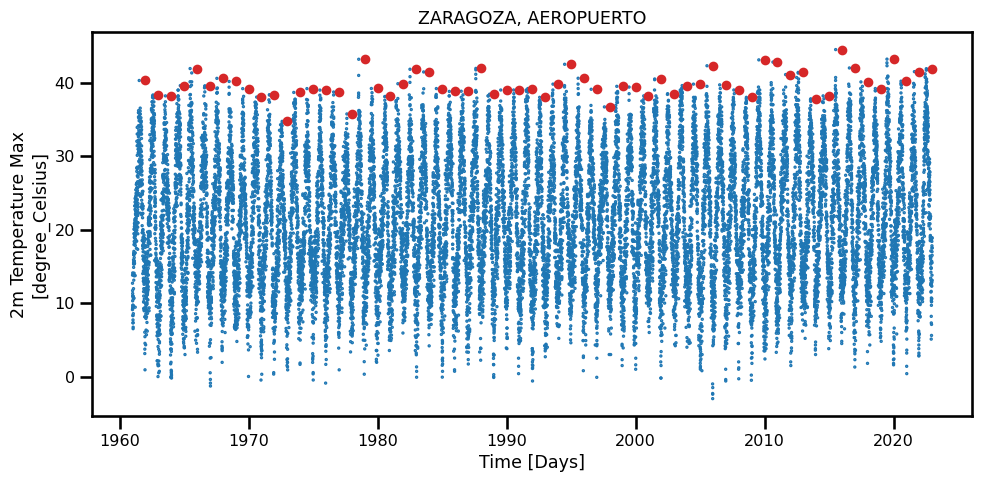

In [10]:
fig, ax = plot_ts_station_bm(ds_station, ds_bm)

# plot_ts_station_bm(ds_station, ds_bm, fig_save_path)
plt.show()

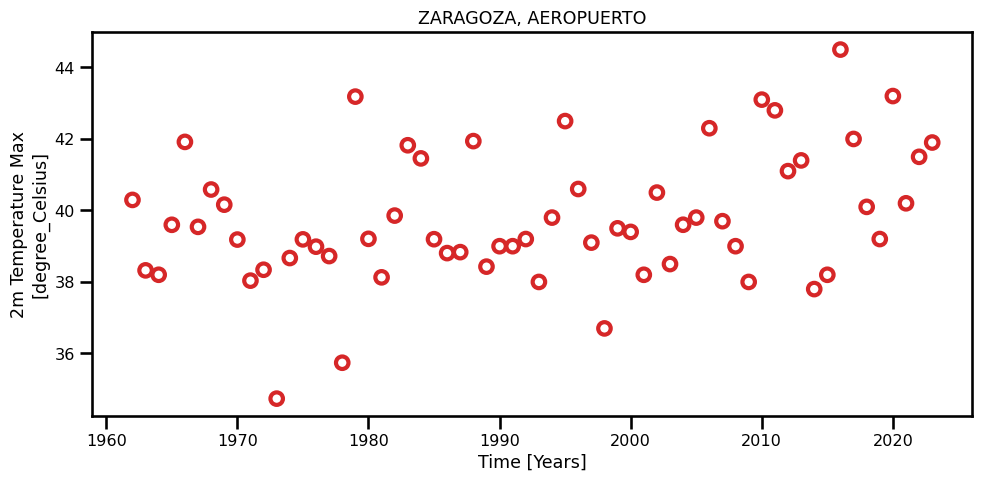

In [11]:
fig, ax = plot_scatter_station(ds_bm)
plt.show()

# plot_scatter_station_bm(ds_bm, fig_save_path)

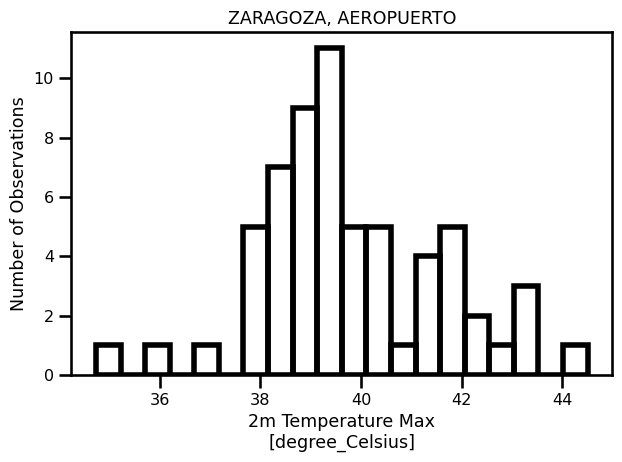

In [12]:
fig, ax = plot_histogram_station(ds_bm)
plt.show()

# plot_histogram_station_bm(ds_bm, fig_save_path)

## Model

We factoized the **Joint Distribution** as so:

$$
p(y,\boldsymbol{\theta}) = p(\boldsymbol{\theta})\prod_{n=1}^N p(y_n|\boldsymbol{\theta})
$$

### Prior & Likelihood

We do a uniform prior for the parameters.

$$
p(\boldsymbol{\theta}) = U(-\infty, \infty)
$$

We use the GEVD for the likelihood.

$$
p(y) \sim \text{GEVD}(\boldsymbol{\theta})
$$

where $\boldsymbol{\theta}=\{\mu,\sigma,\xi\}$ are the location, scale and shape parameters.

In [13]:
y = ds_bm.t2m_max
jnp.mean(y.values)

Array(39.782112, dtype=float32)

In [14]:
y = ds_bm.t2m_max.squeeze()

# initialize GEVD Model
# model = ProbabilisticNormal(
model = ProbGEVDIID.init_from_data(
    y, 
    shape=-0.2, 
    threshold=np.quantile(ds_station.t2m_max, q=0.95)
    # scale=2.0,
)

2024-09-16 11:19:57.320 | INFO     | dynev4eo._src.models.station.gevd:init_from_data:45 - Location: 39.78
2024-09-16 11:19:57.321 | INFO     | dynev4eo._src.models.station.gevd:init_from_data:46 - Scale: 1.83
2024-09-16 11:19:57.321 | INFO     | dynev4eo._src.models.station.gevd:init_from_data:47 - Kurtosis: -0.20
2024-09-16 11:19:57.322 | INFO     | dynev4eo._src.models.station.gevd:init_from_data:48 - Threshold: 35.40
2024-09-16 11:19:57.322 | INFO     | dynev4eo._src.models.station.gevd:init_from_data:49 - Variable Name: t2m_max


In [15]:
with numpyro.handlers.seed(rng_seed=123):
    out = model.model()
    assert y.shape == out.shape
with numpyro.handlers.seed(rng_seed=123):
    out = model.model(y=y)
    assert y.shape == out.shape


### Inference

$$
\boldsymbol{\phi}^* = 
\underset{\boldsymbol{\phi}}{\text{argmin}}
\hspace{2mm}
\text{ELBO}_{q}
\left[q(\boldsymbol{\theta};\boldsymbol{\phi}), p(y,\boldsymbol{\theta})\right]
$$

In [16]:
from dynev4eo._src.inference import SVILearner, MCMCLearner


In [17]:
method = "laplace"
num_steps = 10_000
step_size = 1e-3
clip_norm = 0.1
num_samples = 10

learner = SVILearner(
    model=model.model,
    method=method,
    num_steps=num_steps,
    step_size=step_size,
    clip_norm=clip_norm,
    num_samples=num_samples,
    
    )

In [18]:
# create key
rng_key_train, rng_key = jrandom.split(rng_key, num=2)

# fit MAP estimate
svi_post = learner(rng_key, y=y)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 7012.90it/s, init loss: 348.8549, avg. loss [9501-10000]: 129.9398]


In [19]:
params = svi_post.median_params

In [20]:
num_samples = 10_000
num_warmup = 5_000
mcmc_learner = MCMCLearner(
    model=model.model,
    num_samples=num_samples,
    num_warmup = num_warmup,
    init_params = params
    )

# create key
rng_key_train, rng_key = jrandom.split(rng_key, num=2)

mcmc_post = mcmc_learner(rng_key_train, y=y)

sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [00:03<00:00, 4585.57it/s, 15 steps of size 2.04e-01. acc. prob=0.98]


In [21]:
mcmc_post.mcmc.print_summary(exclude_deterministic=True)


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  concentration     -0.23      0.07     -0.23     -0.35     -0.12   3155.86      1.00
       location     39.09      0.25     39.09     38.66     39.49   4894.68      1.00
          scale      1.88      0.18      1.86      1.58      2.17   3632.97      1.00

Number of divergences: 131


In [22]:
from dynev4eo._src.viz.params import plot_posterior_param_trace, plot_posterior_params_joint
from dynev4eo._src.viz.posterior import plot_posterior_predictive
from dynev4eo._src.viz.returns import plot_return_level_gevd, plot_return_level_hist
from dynev4eo._src.viz.metrics import plot_qq_plot_gevd

In [23]:
def calculate_posterior(mcmc, model, rng_key):
    # get posterior samples
    posterior_samples = mcmc.get_samples()

    # Get Posterior predictive Samples
    posterior_predictive = Predictive(
        model=model.model, posterior_samples=posterior_samples
    )
    # Posterior predictive samples
    rng_key, rng_subkey = jrandom.split(rng_key)
    posterior_predictive_samples = posterior_predictive(rng_subkey)

    # get posterior samples
    posterior_samples = mcmc.get_samples()

    # Get Posterior predictive Samples
    posterior_predictive = Predictive(
        model=model.model, posterior_samples=posterior_samples
    )

    # Posterior predictive samples
    rng_key, rng_subkey = jrandom.split(rng_key)
    posterior_predictive_samples = posterior_predictive(rng_subkey)

    arxiv_summary = az.from_numpyro(
        posterior=mcmc,
        posterior_predictive=posterior_predictive_samples
    )

    # correct some coordinates
    arxiv_summary = arxiv_summary.rename({"return_level_dim_0": "return_period"})
    
    arxiv_summary = arxiv_summary.rename({"obs_dim_0": "time"})

    return arxiv_summary

In [24]:
arxiv_summary = calculate_posterior(mcmc_post.mcmc, model, rng_key=rng_key)

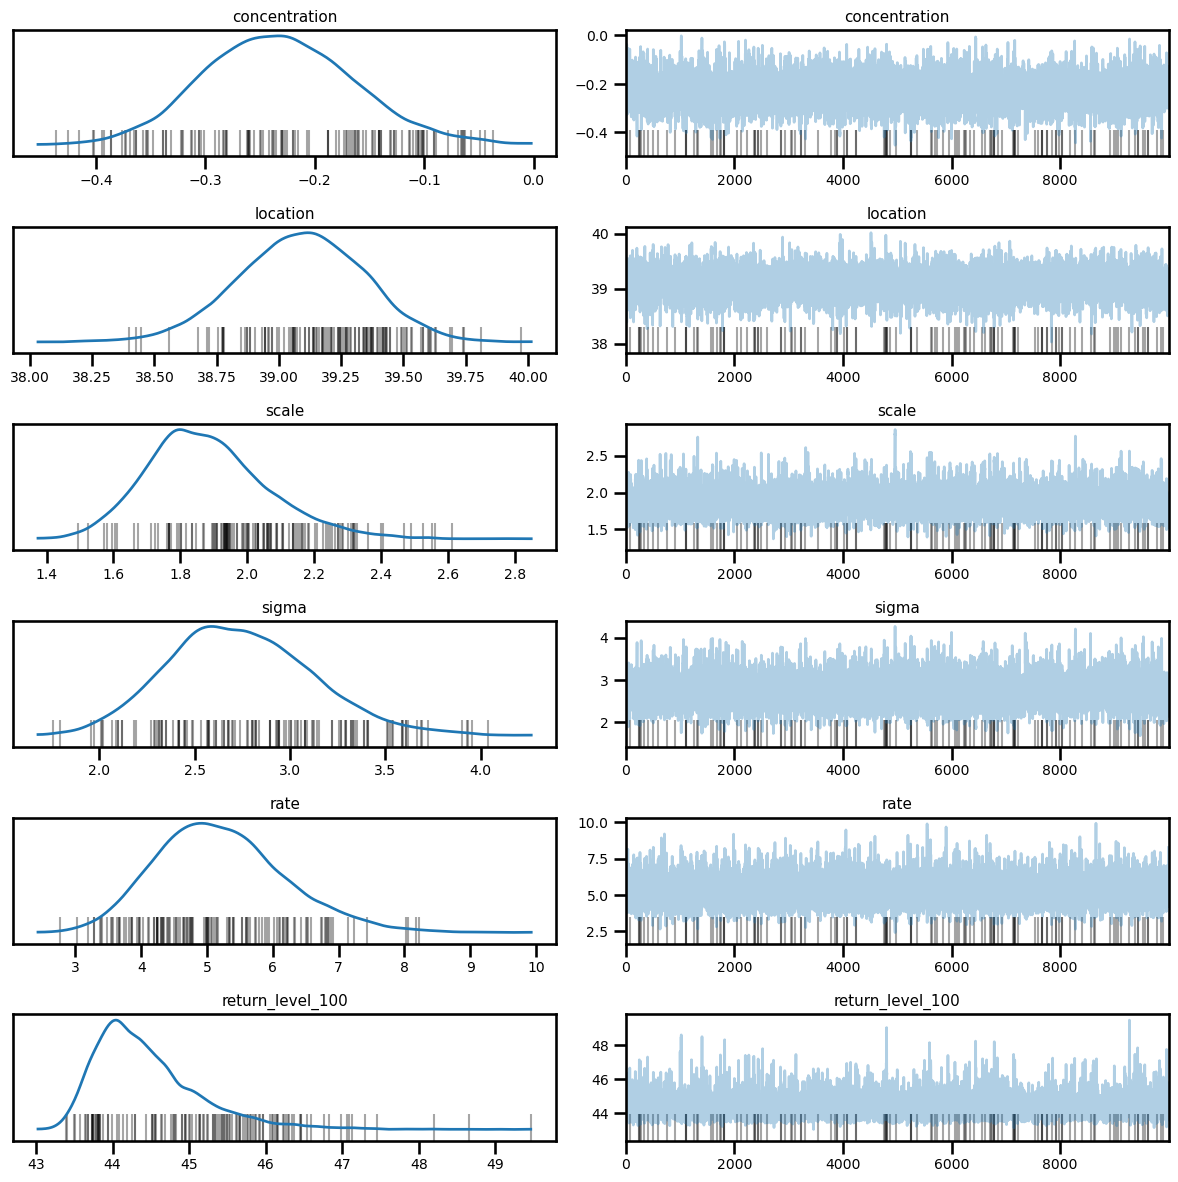

In [25]:
variables = [
    "concentration", "location", "scale", 
    "sigma", "rate",
    "return_level_100",
    ]


fig = plot_posterior_param_trace(arxiv_summary, variables, None)
plt.show()

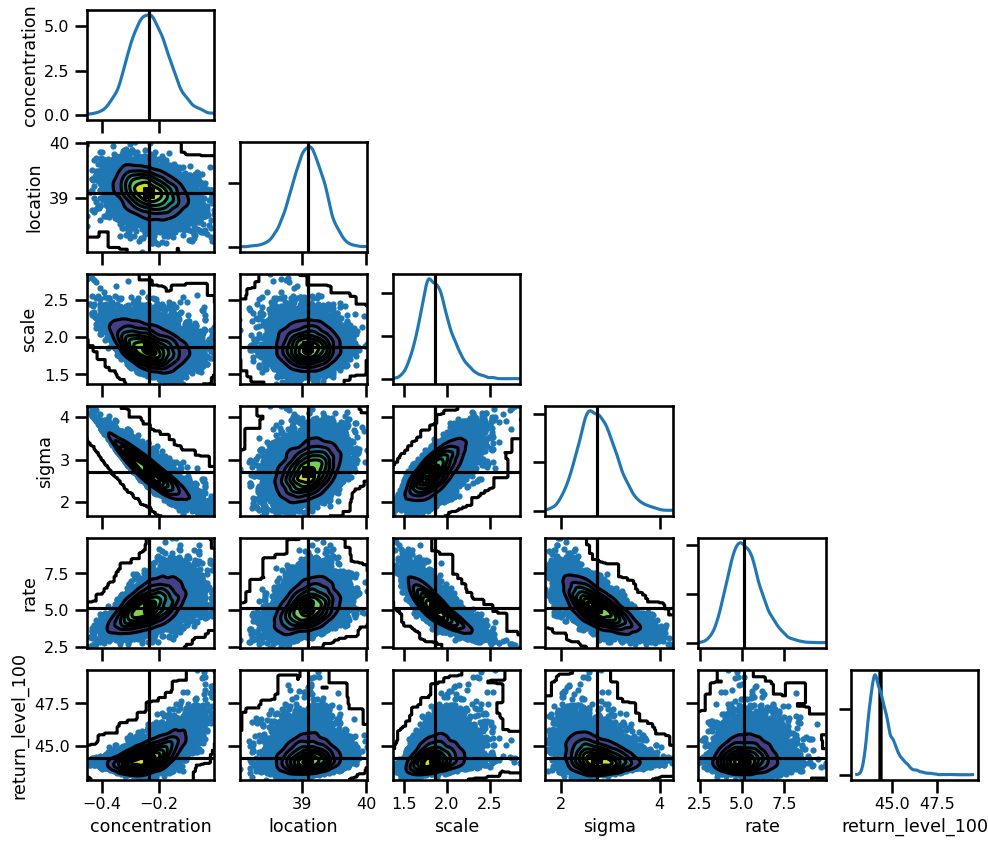

In [26]:
fig = plot_posterior_params_joint(arxiv_summary, variables, None)
plt.show()

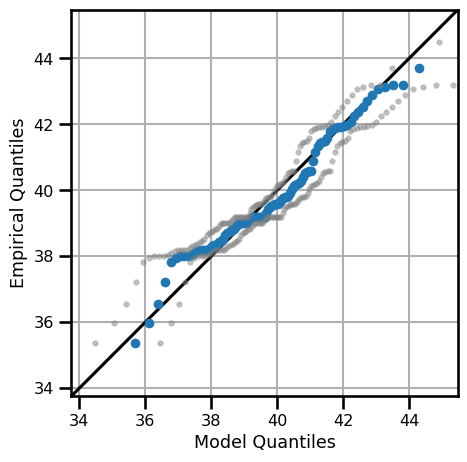

In [27]:
fig = plot_qq_plot_gevd(arxiv_summary, None)
plt.show()

In [28]:
arxiv_summary

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

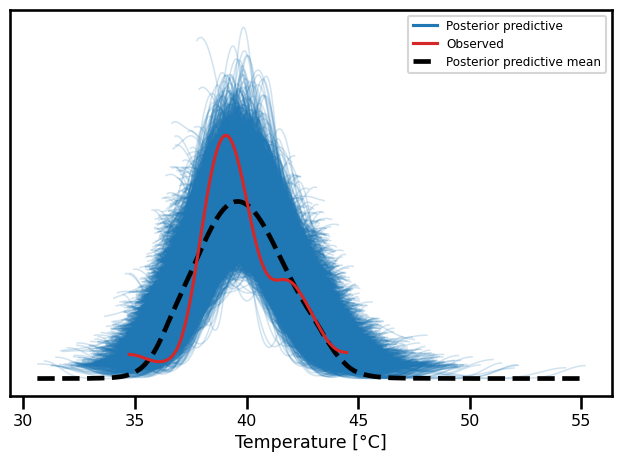

In [29]:
fig = plot_posterior_predictive(arxiv_summary, None)
plt.show()

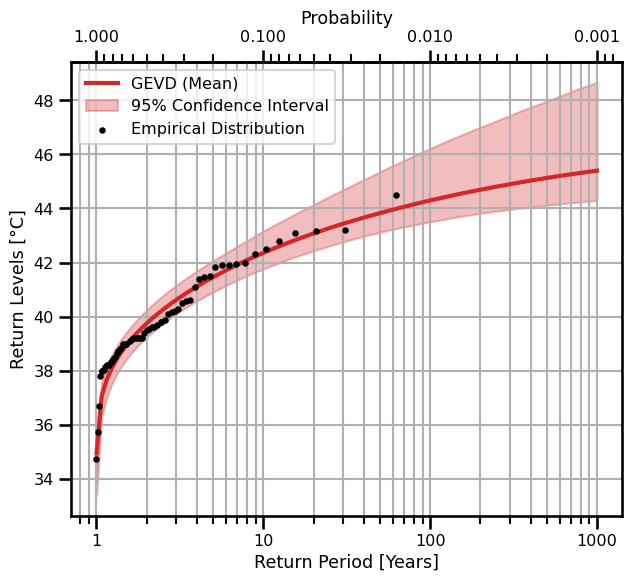

In [30]:
fig = plot_return_level_gevd(arxiv_summary, model, y, None)
plt.show()

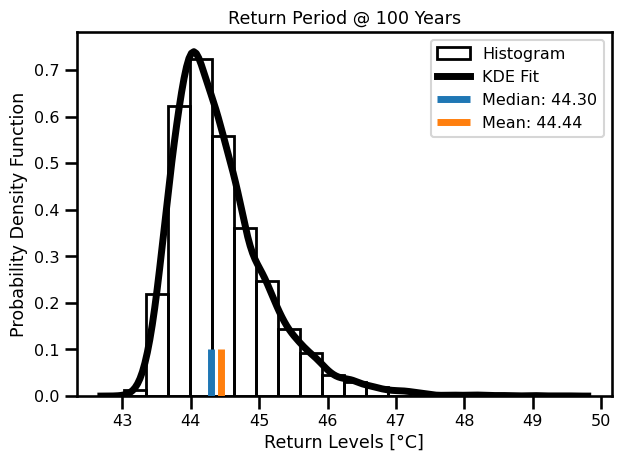

In [31]:
fig = plot_return_level_hist(arxiv_summary, None)
plt.show()

### Analysis

In [32]:
out = az.waic(arxiv_summary, )

out

/home/juanjohn/miniconda/envs/dynev4eo_gpu/lib/python3.10/site-packages/arviz/stats/stats.py:1647: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 10000 posterior samples and 62 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -128.52     6.59
p_waic        3.12        -

There has been a warning during the calculation. Please check the results.